In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import cv2 as cv
import glob
matplotlib.style.use('dark_background')

In [132]:
# Import necessary libraries
from ast import pattern
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import io
from PIL import Image
import glob
import os

def calculate_polygon_area(points):
    """Calculate the area of a polygon given its vertices using the shoelace formula."""
    x = points[:, 0]
    y = points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# Define a function to load and preprocess data from npz files
def load_and_preprocess_data(folder_path, pattern = "*_posture*.npz"):
    data = {}
    files = sorted(glob.glob(os.path.join(folder_path, pattern)))
    min_frame = np.inf
    max_frame = -np.inf
    screen = [np.inf, np.inf, -np.inf, -np.inf]
    print(files)

    for f in files:
        print("loading", f)
        data[f] = {}
        with np.load(f) as npz:
            midline = {}
            offset = npz["offset"]
            frames = npz["frames"]

            if min_frame > frames.min():
                min_frame = frames.min()
            if max_frame < frames.max():
                max_frame = frames.max()

            if offset.T[0].min() < screen[0]:
                screen[0] = offset.T[0].min()
            if offset.T[1].min() < screen[1]:
                screen[1] = offset.T[1].min()

            if offset.T[0].max() > screen[2]:
                screen[2] = offset.T[0].max()
            if offset.T[1].max() > screen[3]:
                screen[3] = offset.T[1].max()

            midline = {}
            if len(npz["midline_points"].shape) == 2:
                i = 0
                indices = []
                for l in npz["midline_lengths"][:-1]:
                    i += l
                    indices.append(int(i))
                points = np.split(npz["midline_points"], indices, axis=0)
                for frame, point, off in zip(frames, points, offset):
                    midline[frame] = point + off
            else:
                for mpt, off, frame in zip(npz["midline_points"], offset, frames):
                    midline[frame] = mpt + off

            i = 0
            indices = []
            for l in npz["outline_lengths"][:-1]:
                i += l
                indices.append(int(i))
            points = np.split(npz["outline_points"], indices, axis=0)
            outline = {}
            for frame, point, off in zip(frames, points, offset):
                outline[frame] = point + off

            # Handle holes
            hole_counts = npz["hole_counts"].astype(int)
            hole_points = npz["hole_points"]
            holes = {}
            count_index = 0
            point_index = 0

            for frame in frames:
                holes[frame] = []
                num_holes = hole_counts[count_index]
                count_index += 1
                
                for _ in range(num_holes):
                    num_points = hole_counts[count_index]
                    count_index += 1
                    
                    if point_index + num_points > len(hole_points):
                        raise Exception(f"Error: index {point_index + num_points} is out of bounds for hole_points with size {len(hole_points)}")
                        break
                    
                    #print(f"{frame}: {num_points} points at index {point_index}")
                    hole = hole_points[point_index:point_index + num_points]
                    holes[frame].append(hole)
                    point_index += num_points

            data[f]["holes"] = holes
            data[f]["midline"] = midline
            data[f]["outline"] = outline

    screen[0] -= 10
    screen[1] -= 10
    screen[2] *= 1.1
    screen[3] *= 1.1
    input_shape = (screen[2] - screen[0], screen[3] - screen[1])
    #output_width = 1280
    output_width = input_shape[0]
    output_shape = (output_width, int(output_width * input_shape[1] / input_shape[0]))  # Adjust output resolution to maintain aspect ratio
    fps = 40.0

    return data, screen, input_shape, output_shape, fps, min_frame, max_frame

data, screen, input_shape, output_shape, fps, min_frame, max_frame = load_and_preprocess_data("/Users/tristan/Videos/data/", pattern = "*_posture*.npz")

['/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish0.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish1.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish2.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish3.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish4.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish5.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish6.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish7.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish8.npz', '/Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish9.npz']
loading /Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish0.npz
loading /Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish1.npz
loading /Users/tristan/Videos/data/20240301_082933912_DJI_0261_posture_fish2.

In [133]:
df = []

for file in glob.glob("/Users/tristan/Videos/data/20240301_082933912_DJI_0261_fish*.npz"):
    fdx = int(file.split("_")[-1].split(".")[0].split("fish")[-1])
    #print(fdx)
    with np.load(file) as npz:
        _df = pd.DataFrame()
        
        # find the poseX<n> and poseY<n> keys that are not np.inf throughout
        keys = sorted([key for key in npz.keys() if (key.startswith("poseX")) and not np.isinf(npz[key]).all()])

        # pair the X and Y keys together and add them to the dataframe
        # as columns named "X" and "Y"
        poses = []
        for key in keys:
            if key.startswith("poseX"):
                X = npz[key]
                Y = npz[key.replace("poseX", "poseY")]
                vectors = np.array((X, Y))
                poses.append(vectors)
        poses = np.array(poses).T#.reshape(-1, len(keys), 2)

        # group the X and Y columns together to create a single "pose" column
        # with the format [(poseX0, poseY0), (poseX1, poseY1), ...]
        print(poses.shape)
        #assert len(poses) == len(npz["frame"])
        _df["pose"] = poses.tolist()

        # add other keys
        keys = ["frame"]
        for key in keys:
            _df[key] = npz[key]

        _df["fdx"] = fdx
        df.append(_df)

df = pd.concat(df, ignore_index=True)



(1945, 2, 9)
(1, 2, 1)
(1148, 2, 9)
(975, 2, 9)
(5565, 2, 9)
(6860, 2, 9)
(3797, 2, 9)
(1, 2, 9)
(3805, 2, 9)
(1, 2, 8)
(1, 2, 9)
(1, 2, 9)
(3834, 2, 9)
(5665, 2, 9)
(3139, 2, 9)
(3137, 2, 9)
(1, 2, 7)
(1, 2, 1)
(1, 2, 9)
(1, 2, 7)
(6116, 2, 9)
(1, 2, 9)
(1, 2, 9)
(3, 2, 8)
(1, 2, 9)
(2, 2, 8)
(1, 2, 9)
(3801, 2, 9)
(3765, 2, 9)
(1984, 2, 9)
(1989, 2, 9)
(1290, 2, 4)
(1984, 2, 9)
(1886, 2, 9)
(1889, 2, 9)
(1931, 2, 9)
(1891, 2, 5)


[[3511.0, 1566.0], [3430.0, 1705.0], [3517.0, 1735.0], [3604.0, 1683.0], [3517.0, 1812.0], [3520.0, 1886.0], [3526.0, 1932.0], [3546.0, 1998.0], [3574.0, 2059.0]]
                                                    pose  frame  fdx
61437  [[3511.0, 3430.0, 3517.0, 3604.0, 3517.0, 3520...   95.0    1


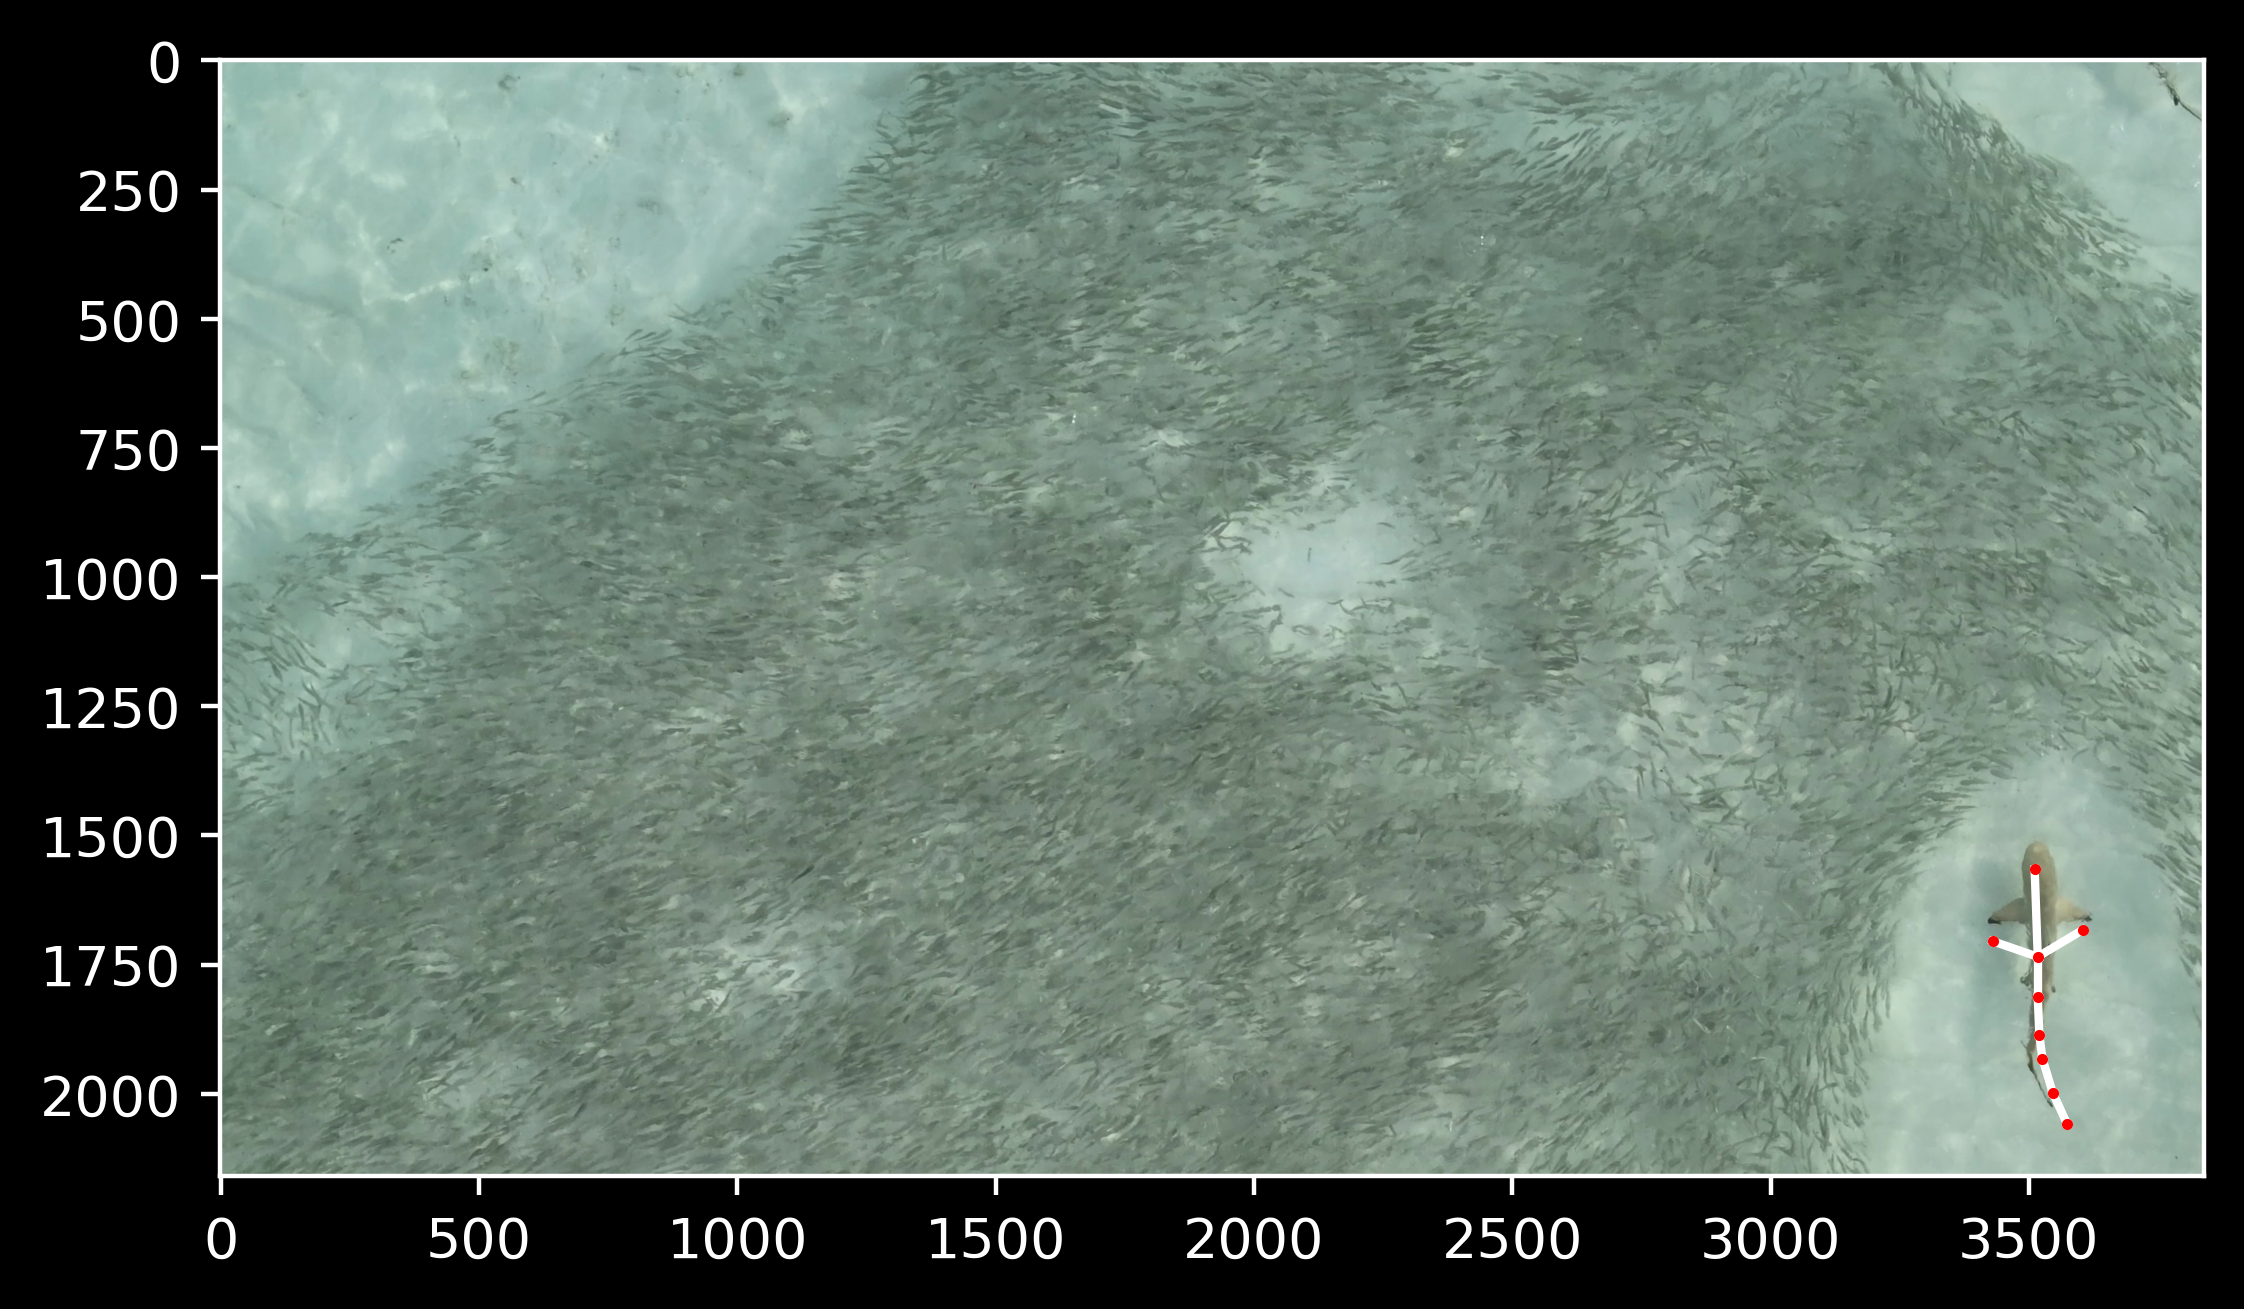

In [77]:
skeleton = ["shark",[[0,2],[1,2],[3,2],[2,4],[4,5],[5,6],[6,7],[7,8]]]
video_file = "/Volumes/Public/work/shark/videos/20240301_082933912_DJI_0261.MP4"
cap = cv.VideoCapture(video_file)
frame_index = 0

# plot a single frame
frame = df.iloc[0]["frame"]
cap.set(cv.CAP_PROP_POS_FRAMES, frame)
ret, img = cap.read()
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# plot the fish
sub = df[(df["frame"] == frame) & (df["fdx"] == 1)]
pose = np.array(sub.pose.values[0]).T
print(pose.tolist())

plt.figure(dpi=400)
for i, (x, y) in enumerate(skeleton[-1]):
    plt.plot([pose[x][0], pose[y][0]], [pose[x][1], pose[y][1]], 'w-')
    plt.plot(pose[x][0], pose[x][1], 'wo', markersize=1)
    plt.plot(pose[y][0], pose[y][1], 'wo', markersize=1)
    #plt.text(pose[x][0], pose[x][1], str(x), color='w')
    #plt.text(pose[y][0], pose[y][1], str(y), color='w')

plt.plot(pose.T[0], pose.T[1], 'ro', markersize=1)
print(sub)

plt.imshow(img)
plt.show()
cap.release()

/var/folders/qw/tls_h_cx4k11qqvkl3z991v00000gn/T/ipykernel_42907/1642412259.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('cool')


[[inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf]]
[[inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf]]
[[2204.0, 431.0], [2065.0, 324.0], [2019.0, 412.0], [2063.0, 527.0], [1947.0, 400.0], [1874.0, 382.0], [1819.0, 354.0], [1763.0, 320.0], [1709.0, 307.0]]
[[3136.0, 956.0], [2982.0, 940.0], [2991.0, 1048.0], [3082.0, 1102.0], [2914.0, 1095.0], [2853.0, 1127.0], [2805.0, 1143.0], [2742.0, 1144.0], [2668.0, 1117.0]]
[[inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf]]
[[inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf]]
[[766.0, 413.0], [602.0, 473.0], [655.0, 570.0], [761.0, 578.0], [599.0, 633.0], [549.0, 700.0], [510.0, 756.0], [495.0, 812.0], [477.0, 886.0]]
[[inf, inf], [inf, inf], [inf, inf], [inf, inf], [inf, inf]]
/Users/tristan/Videos/data/20240301_0829339

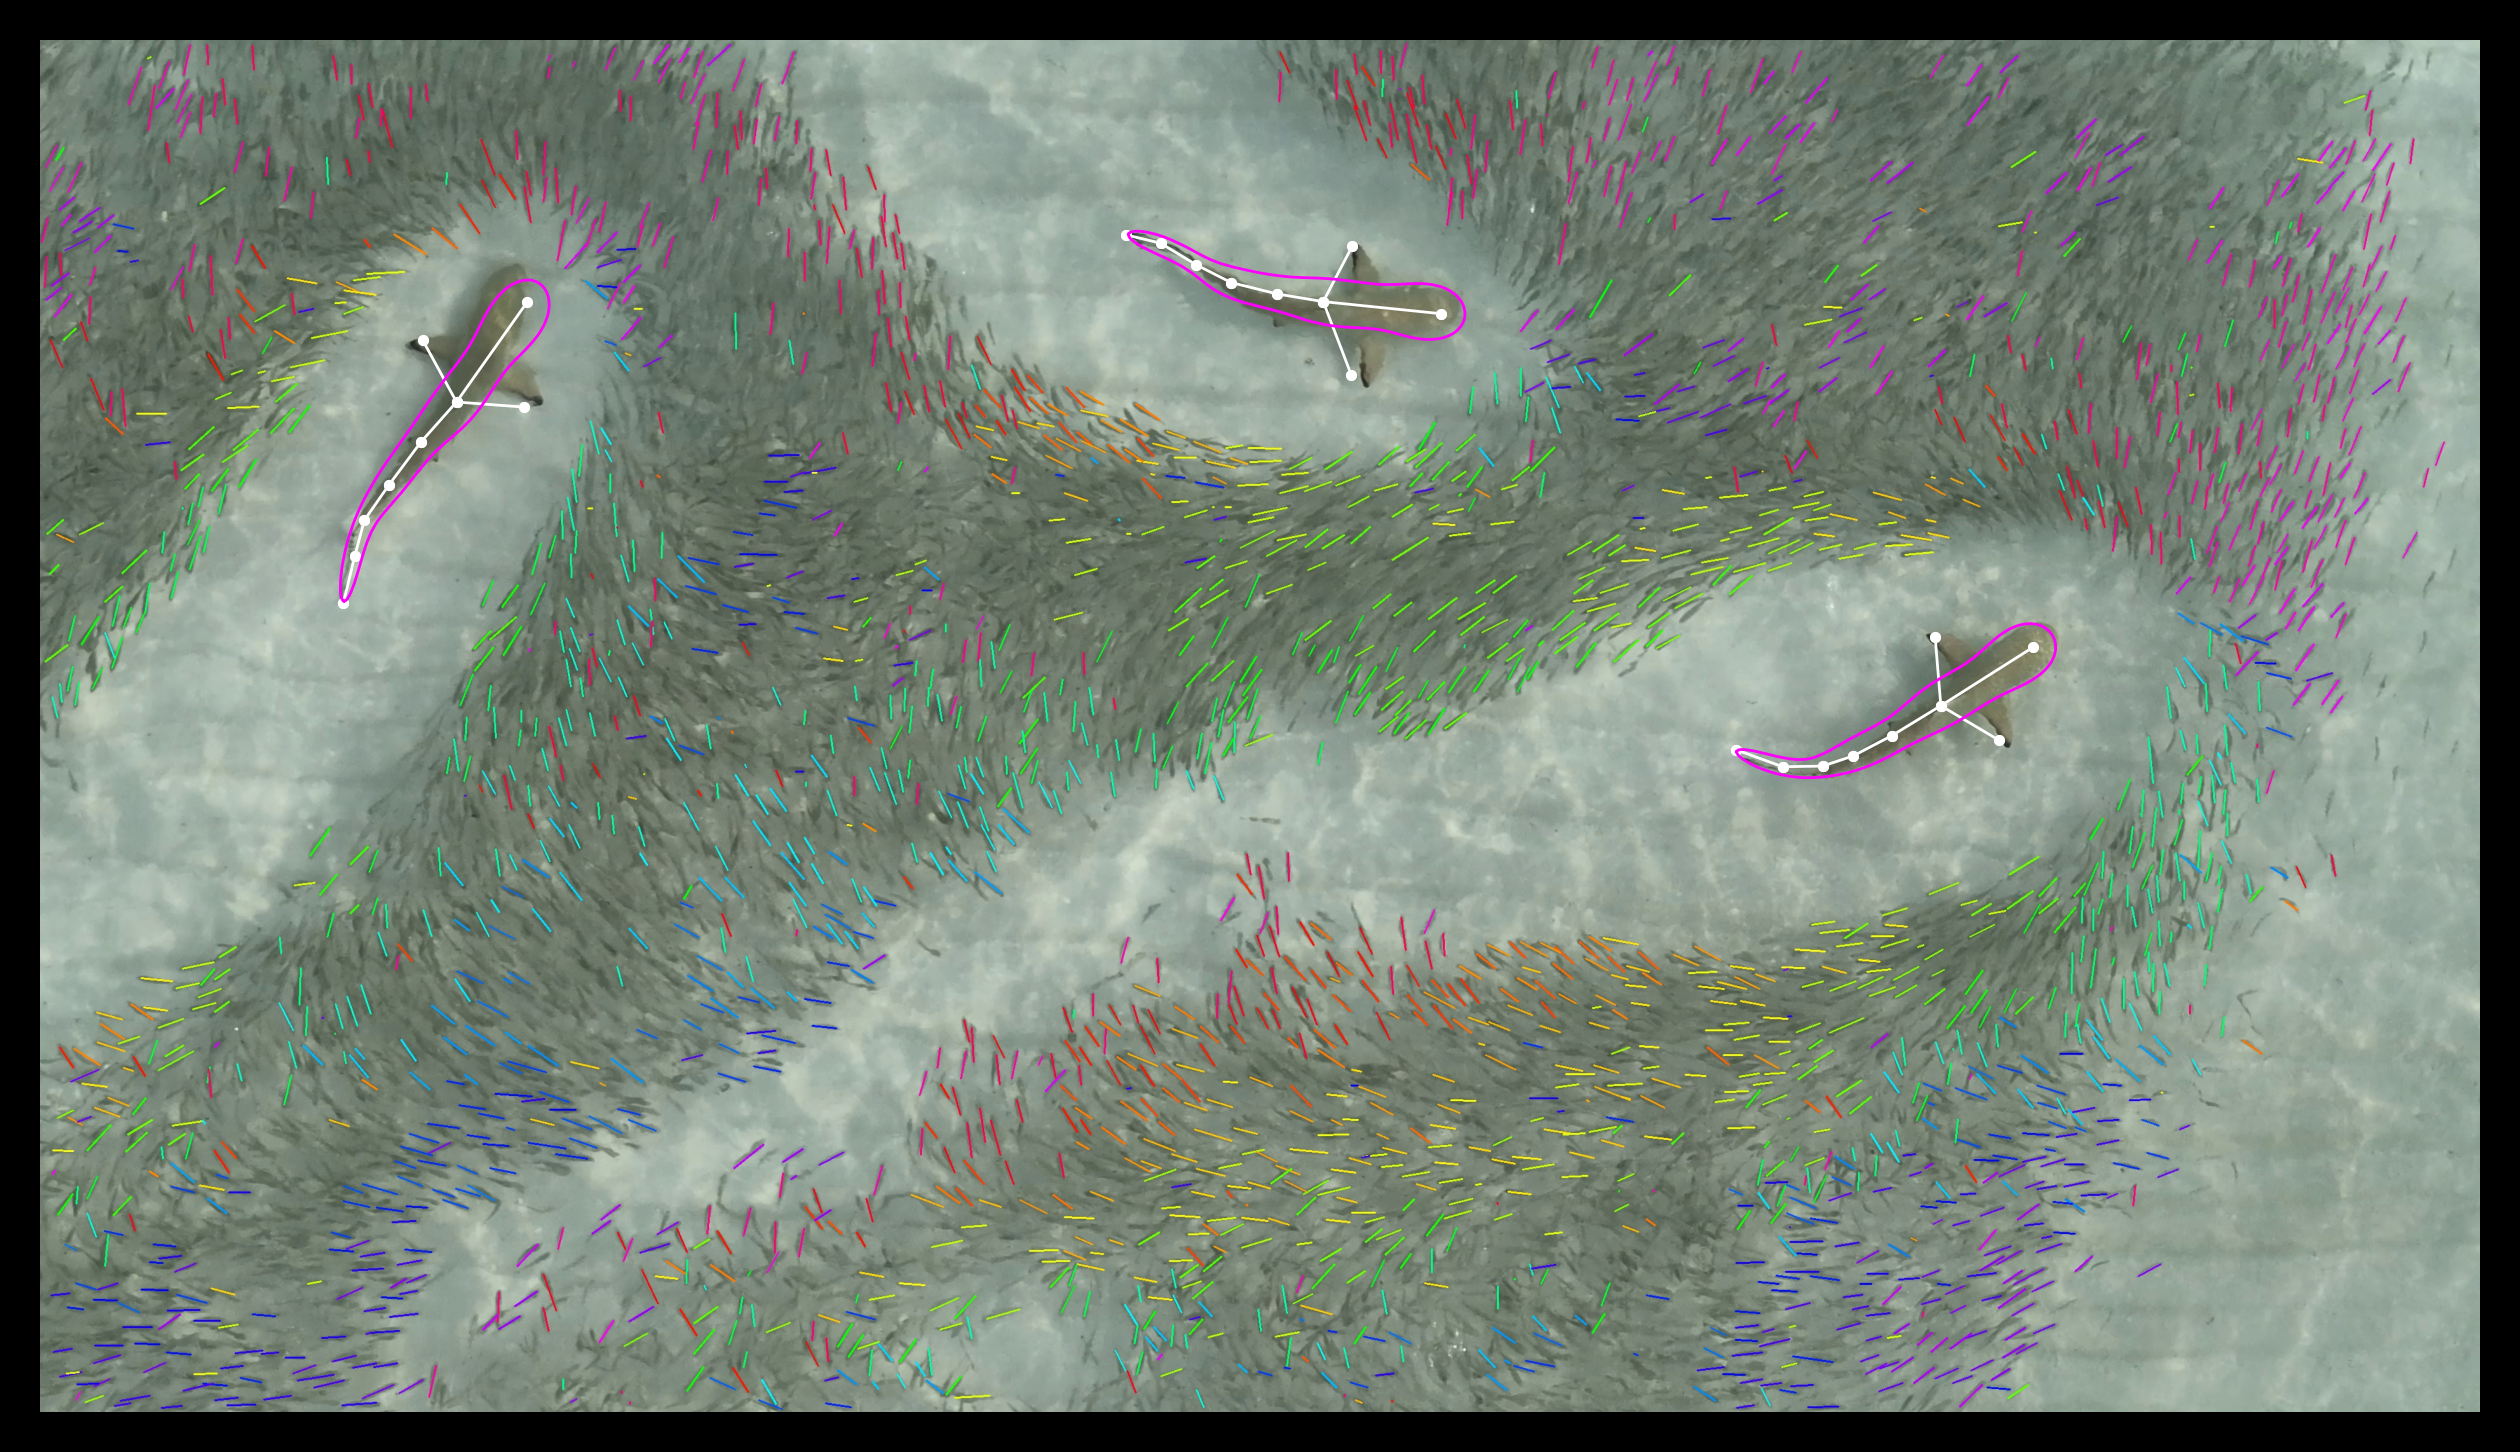

In [148]:

import matplotlib.patches as patches
import matplotlib.cm as cm

# plot a single frame
frame = 1794 #df.iloc[0]["frame"]
cap.set(cv.CAP_PROP_POS_FRAMES, frame)
#ret, img = cap.read()
img = cv.imread("/Users/tristan/Downloads/frame_1794.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# plot the fish
sub = df[(df["frame"] == frame)] #& (df["fdx"] == 1)]

f = plt.figure(dpi=400)
ax = f.gca()
plt.imshow(img)

colormap = cm.get_cmap('cool')

for pose in sub.pose.values:
    pose = np.array(pose).T
    print(pose.tolist())

    for i, (x, y) in enumerate(skeleton[-1]):
        if x >= len(pose) or y >= len(pose):
            continue
        if np.isinf(pose[x][0]) and np.isinf(pose[y][0]):
            continue
        plt.plot([pose[x][0], pose[y][0]], [pose[x][1], pose[y][1]], 'w-', linewidth=0.5)
        plt.plot(pose[x][0], pose[x][1], 'o', markersize=1, color='lightgray')
        plt.plot(pose[y][0], pose[y][1], 'wo', markersize=1)

    plt.plot(pose.T[0], pose.T[1], 'o', markersize=1, color='white')

for key in data:
    print(key)
    if frame not in data[key]["outline"]:
        continue
    outline = np.array(data[key]["outline"][frame])
    ax.plot(outline.T[0], outline.T[1], label="outline", color=colormap(1.3), linewidth=0.5)
    #ax.scatter(outline.T[0], outline.T[1], label="outline", color=colormap(0.6), s=0.5, alpha=0.5)

    midline = data[key]["midline"]
    m = midline[frame]
    #ax.scatter(m.T[0], m.T[1], label="midline", s=0.5, color=colormap(0.9))

    # Draw holes
    '''hole_area = 0
    for hole in data[key]["holes"][frame]:
        ax.scatter(hole.T[0], hole.T[1], label="hole", s=1, color='grey')
        hole_area += calculate_polygon_area(hole)'''
    

#ax.text(0.45, 0.05, f"Frame: {frame}", fontsize=8, color='lightgrey', 
#        bbox=dict(facecolor='black', alpha=0.7, edgecolor='white', boxstyle='round,pad=0.5'),
#        font='monospace', clip_on=True, transform=ax.transAxes)

print(sub)
plt.axis('off')
plt.tight_layout()
plt.show()


In [1]:
import cv2

# Load the video file
video_path = '/Users/tristan/reversals3m_1024_dotbot_20181025_105202.stitched/000040.mp4'  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error opening video file")

# Get the total number of frames
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Total number of frames: {frame_count}")

# Release the video capture object
cap.release()

Total number of frames: 17
